In [86]:
# If you get a ModuleNotFound error install koinapy with `pip install koinapy`.
from koinapy import Koina
import numpy as np
import pandas as pd
import re
from copy import deepcopy
dfI = pd.read_csv("dfI.csv")[['modified_sequence', 'precursor_charge', 'aligned_collision_energy']]
dfI = dfI.rename(columns={"modified_sequence": "peptide_sequences", 'precursor_charge': 'precursor_charges' , 'aligned_collision_energy': 'collision_energies'})
dfI['instrument_types'] = pd.Series(len(dfI)*['LUMOS'])
dfL = deepcopy(dfI)
dfL['peptide_sequences'] = dfL['peptide_sequences'].map(lambda x: re.sub('I', 'L', x))

In [87]:
dfI = dfI.iloc[np.arange(0, 100000, 10)]
dfL = dfL.iloc[np.arange(0, 100000, 10)]

In [88]:
# If you are unsure what inputs your model requires run `model.model_inputs`
model = Koina("UniSpec", "koina.wilhelmlab.org:443")

predictionsI = model.predict(dfI)
predictionsI['annotation'] = predictionsI['annotation'].map(lambda x: x.decode("utf-8"))

predictionsL = model.predict(dfL)
predictionsL['annotation'] = predictionsL['annotation'].map(lambda x: x.decode("utf-8"))

UniSpec::   0%|          | 0/10 [00:00<?, ?it/s]

UniSpec::   0%|          | 0/10 [00:00<?, ?it/s]

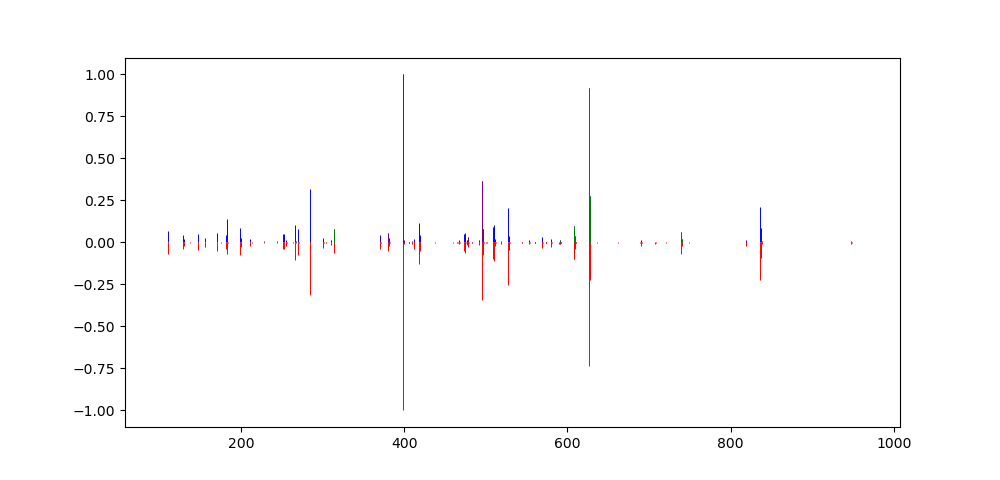

In [44]:
%matplotlib widget
import matplotlib.pyplot as plt
plt.close('all')
fig,ax = plt.subplots()
fig.set_figwidth(10)

predI = predictionsI.query(f"peptide_sequences == '{predictions}' and peptide_sequences.str.contains('I')")
beeI = predI.query(f"annotation.str.contains('b5|b4')")
whyI = predI.query(f"annotation.str.contains('y5|y6')")
predL = predictionsL.query(f"peptide_sequences == '{predictions}' and peptide_sequences.str.contains('L')")
beeL = predL.query(f"annotation.str.contains('b5|b4')")
whyL = predL.query(f"annotation.str.contains('y5|y6')")

ax.vlines(predI['mz'], ymin=0, ymax=predI['intensities'], color='b', linewidth=0.7)
ax.vlines(predL['mz'], ymin=-predL['intensities'], ymax=0, color='r', linewidth=0.7)
ax.vlines(bee['mz'], ymin=0, ymax=bee['intensities'], color='purple', linewidth=0.7)
ax.vlines(why['mz'], ymin=0, ymax=why['intensities'], color='green', linewidth=0.7)

In [89]:
import metrics as M
keys = [m for m in dir(M) if ((m[:2]!='__')&(m!='binarize')&(m!='normalize'))]
keys = [
    'mse',
    'sequest_score',
    'andromeda_score',
    'pearson_correlation',
    'spearman_correlation',
    'dot_product',
    'mara_similarity',
    'modified_dot_product',
    'massbank_score',
    'gnps_score',
    'stein_scott_score',
    'wasserstein',
    'kendall_tau',
    'mutual_information',
    'bray_curtis',
    'canberra_distance',
    'mara_weighted_similarity',
    'diagnostic_weighted_similarity'
]

In [90]:
dic = {'peptideL':[], 'peptideI':[]}
for i in range(len(dfI)):
    pepI = dfI['peptide_sequences'].iloc[i]
    charI = dfI['precursor_charges'].iloc[i]
    energyI = dfI['collision_energies'].iloc[i]
    predI = predictionsI.query(f"peptide_sequences == '{pepI}' and precursor_charges == {charI} and collision_energies == {energyI}")
    beeI = predI.query(f"annotation.str.contains('b5|b4')")
    whyI = predI.query(f"annotation.str.contains('y5|y6')")
    
    pepL = dfL['peptide_sequences'].iloc[i]
    charL = dfL['precursor_charges'].iloc[i]
    energyL = dfL['collision_energies'].iloc[i]
    predL = predictionsL.query(f"peptide_sequences == '{pepL}' and precursor_charges == {charL} and collision_energies == {energyL}")
    beeL = predL.query(f"annotation.str.contains('b5|b4')")
    whyL = predL.query(f"annotation.str.contains('y5|y6')")
    
    dic['peptideL'].append(pepL)
    dic['peptideI'].append(pepI)
    
    # Find all matching annotations
    cross_ref = predI['annotation'].to_numpy()[None] == predL['annotation'].to_numpy()[:,None]
    match_mask = cross_ref.sum(1)==1
    ann_inds2 = cross_ref[match_mask].argmax(1)
    
    # Truncated dataframes for matches
    predL_ = predL[match_mask]
    predI_ = predI.iloc[ann_inds2]
    
    # Run through and print out similarity scores
    for key in keys:
        if key not in dic:
            dic[key] = []
        inp = {
            'intensity1': predL_['intensities'].to_numpy(),
            'intensity2': predI_['intensities'].to_numpy(),
            'mz1': predL_['mz'].to_numpy(),
            'mz2': predI_['mz'].to_numpy(),
            'diagnostic_mz': pd.concat([beeI, whyI])['mz'].to_numpy(),
            'mz': predL_['mz'].to_numpy(),
        }
        try:
            score = getattr(M, key)(**inp)
        except:
            score = 0
        dic[key].append(score)
df = pd.DataFrame(dic)

/cmnfs/home/j.lapin/miniconda3/envs/torch/lib/python3.11/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/cmnfs/home/j.lapin/miniconda3/envs/torch/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/cmnfs/home/j.lapin/projects/spectral_similarity/metrics.py:47: RuntimeWarning: invalid value encountered in scalar divide
  return sim / np.sum(np.maximum(intensity1, intensity2))
/cmnfs/home/j.lapin/projects/spectral_similarity/metrics.py:52: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(weights * intensity1 * intensity2) / (
/cmnfs/home/j.lapin/projects/spectral_similarity/metrics.py:58: RuntimeWarning: invalid value encountered in scalar divide
  score = np.sum(intensity1 * intensity2) / (np.sum(intensity1**2) + np.sum(intensity2**2) - np.sum(intensity1 * intensity2))
/cmnfs/home/j.lapin/p

KeyboardInterrupt: 

/tmp/ipykernel_3317942/2064726873.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.yaxis.set_ticklabels(ax.yaxis.get_ticklabels(), size=7)
/tmp/ipykernel_3317942/2064726873.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.yaxis.set_ticklabels(ax.yaxis.get_ticklabels(), size=7)
/tmp/ipykernel_3317942/2064726873.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.yaxis.set_ticklabels(ax.yaxis.get_ticklabels(), size=7)
/tmp/ipykernel_3317942/2064726873.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.yaxis.set_ticklabels(ax.yaxis.get_ticklabels(), size=7)
/cmnfs/home/j.lapin/miniconda3/envs/torch/lib/python3.11/site-packages/numpy/lin

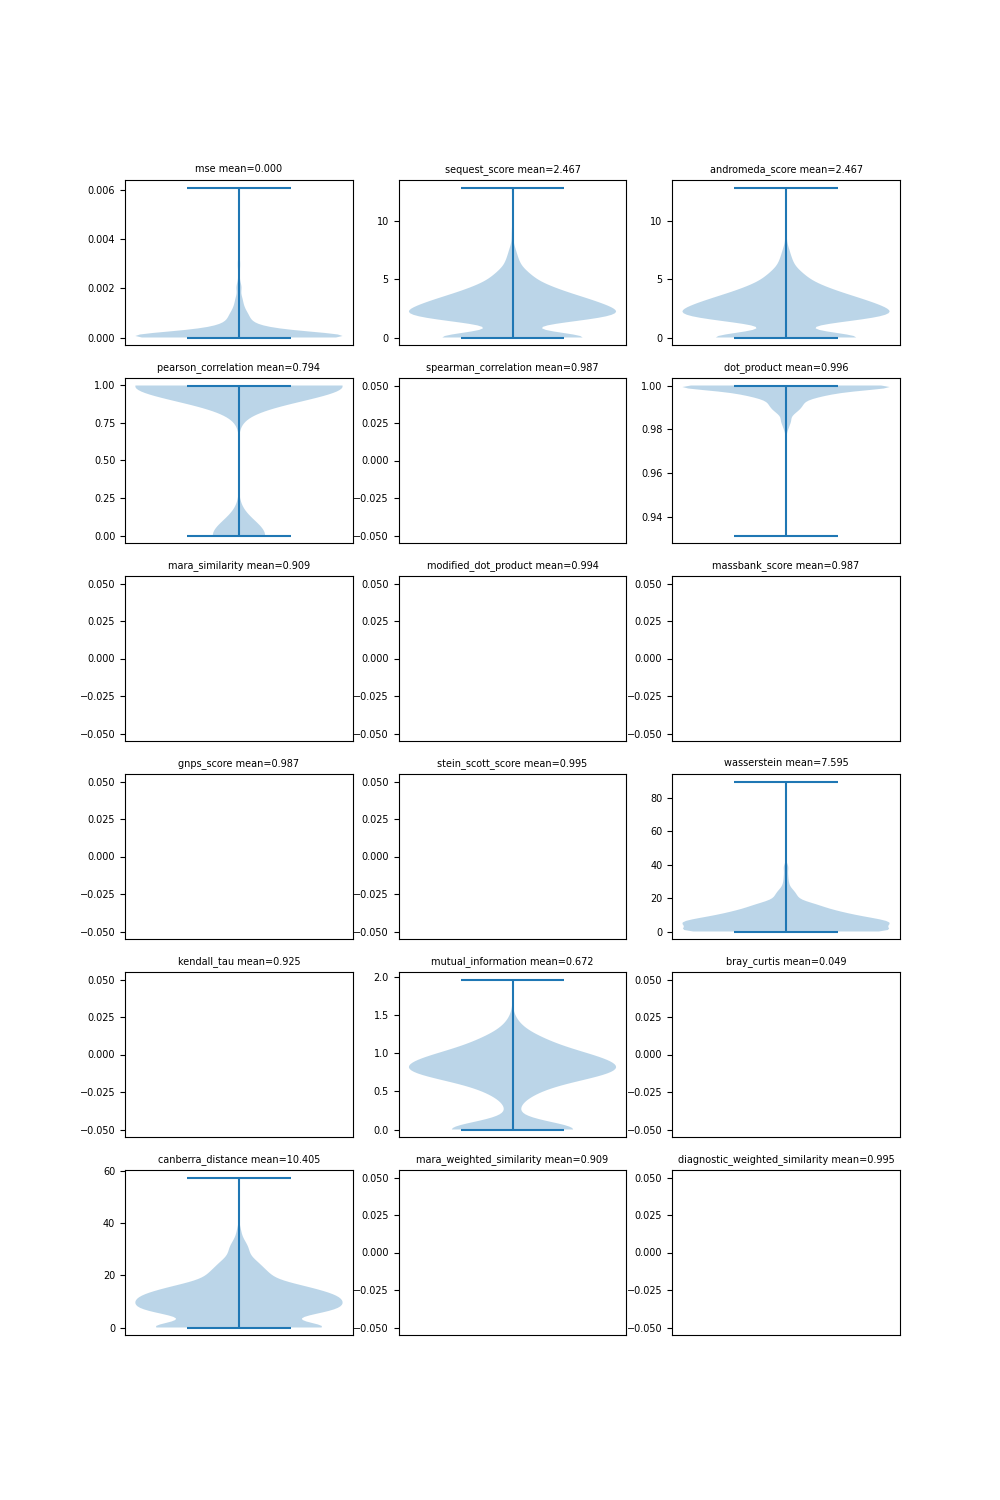

In [91]:
%matplotlib widget
import matplotlib.pyplot as plt
plt.close('all')

fig, axes = plt.subplots(6, 3)
fig.set_figwidth(10)
fig.set_figheight(15)
for ax, key in zip(axes.flatten(), keys):
    ax.violinplot(df[key])
    ax.set_title(f"{key} mean={df[key].mean():.3f}", size=7)
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticklabels(ax.yaxis.get_ticklabels(), size=7)